# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Functions definition

In [2]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda
from Fonctions import get_3D_budget_xarr
from Fonctions import get_3D_xarr
from Fonctions import get_3D_SW_xarr
from Fonctions import get_3D_LW_xarr

# official, membre p1

In [3]:
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
E_p1={}
variables = ['tas', 'pr', 'SW', 'LW']

for i in variables :

    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+i+'.npy')
    pc1_obs = U_obs[0]
    pc2_obs = U_obs[1]
    pc3_obs = U_obs[2]
    pc4_obs = U_obs[3]
    pc5_obs = U_obs[4]

    pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+i+'.npy')
    pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+i+'.npy')
    pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+i+'.npy')
    pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+i+'.npy')
    pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+i+'.npy')

    E_p1_tmp = (pc1_p1-pc1_obs)**2 + (pc2_p1-pc2_obs)**2 + (pc3_p1-pc3_obs)**2 + (pc4_p1-pc4_obs)**2 + (pc5_p1-pc5_obs)**2
    E_p1['E_p1_'+i] = sqrt(E_p1_tmp/5)
        
E_p1

{'E_p1_tas': 2.3666373918035335,
 'E_p1_pr': 1.9992507462199554,
 'E_p1_SW': 1.6642489996403333,
 'E_p1_LW': 1.0078263180593994}

# CFMIP models

In [4]:
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

CFMIP_list = ['MRI', 'CAN', 'MIROC', 'HadGEM3', 'IPSL', 'BCC']

# Likelihood

In [19]:
Likelihood_df = pd.DataFrame()
variables = ['tas', 'pr', 'SW', 'LW']

OSE_tmp=0
E1_tmp = 0
tmp1=0
tmp2=0
for j in variables :
    tmp1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+j+'.npy')
    OSE_tmp = OSE_tmp + tmp1

    tmp2 = E_p1['E_p1_'+j]
    E1_tmp = E1_tmp + tmp2
    
OSE_total = OSE_tmp/len(variables)
E_p1['E_p1_total'] = E1_tmp/len(variables)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy', OSE_total)


variables = ['tas', 'pr', 'SW', 'LW', 'total']
RMSE_optim2={}
Fdbck_optim2={}
for i in variables :
    RMSE_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+i+'.npy')
    Fdbck_optim2[i] = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+i+'.npy')
    OSE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_total.npy')
    
    E_p1_tmp = E_p1['E_p1_'+i]
    L = []
    for j in RMSE_optim2[i] :
        tmp = exp(-(j-E_p1_tmp)/(4*OSE))
        tmp_2 = tmp/sqrt(OSE)*1/100
        L.append(tmp_2)


    Likelihood_df['Fdbck_'+i] = Fdbck_optim2[i]
    Likelihood_df['Fdbck_likelihood_'+i] = L


Likelihood_df['Fdbck_likelihood_total'] = (Likelihood_df['Fdbck_likelihood_tas']+Likelihood_df['Fdbck_likelihood_pr']+Likelihood_df['Fdbck_likelihood_SW']+Likelihood_df['Fdbck_likelihood_LW'])/4
Likelihood_df

,Fdbck_tas,Fdbck_likelihood_tas,Fdbck_pr,Fdbck_likelihood_pr,Fdbck_SW,Fdbck_likelihood_SW,Fdbck_LW,Fdbck_likelihood_LW,Fdbck_total,Fdbck_likelihood_total
0,-1.985756,0.134676,-1.985956,0.011292,-1.985756,0.041354,-1.985856,0.012887,-1.985856,0.050052
1,-1.971646,0.068181,-1.971867,0.012155,-1.971593,0.045840,-1.971717,0.013324,-1.971674,0.034875
2,-1.957589,0.072701,-1.957830,0.013069,-1.957483,0.050058,-1.957630,0.013778,-1.957546,0.037402
3,-1.943636,0.077195,-1.943896,0.014030,-1.943531,0.044985,-1.943647,0.014255,-1.943522,0.037616
4,-1.929903,0.081133,-1.930110,0.015033,-1.929673,0.048925,-1.929812,0.014760,-1.929651,0.039963
...,...,...,...,...,...,...,...,...,...,...
108,-0.834420,0.388315,-0.834092,0.176701,-0.834401,0.081388,-0.833948,0.023928,-0.834363,0.167583
109,-0.821019,0.358371,-0.820746,0.169419,-0.820983,0.076601,-0.820638,0.021497,-0.820918,0.156472
110,-0.807434,0.333989,-0.807271,0.162041,-0.807431,0.071933,-0.807214,0.019546,-0.807335,0.146877
111,-0.793785,0.307420,-0.793708,0.154676,-0.793789,0.067431,-0.793690,0.017356,-0.793656,0.136721


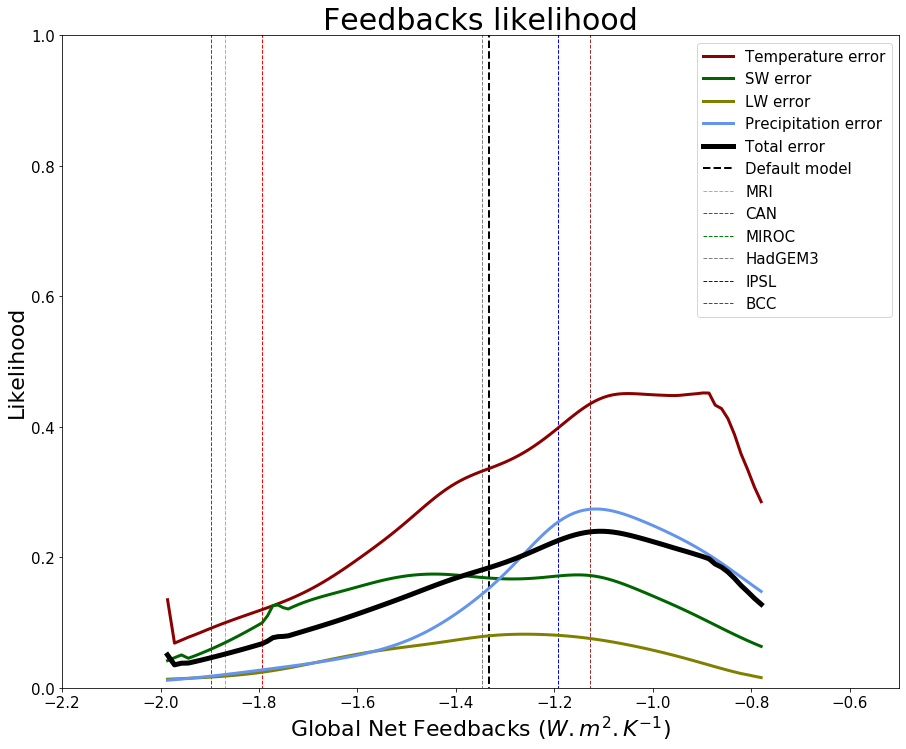

In [20]:
ax = plt.gca()



Likelihood_df.plot(kind='line', x='Fdbck_tas', y='Fdbck_likelihood_tas', color = 'darkred', 
         linewidth=3, figsize=(15, 12),  ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_SW', y='Fdbck_likelihood_SW', color = 'darkgreen', 
         linewidth=3,  ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_LW', y='Fdbck_likelihood_LW', color = 'olive', 
         linewidth=3,  ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_pr', y='Fdbck_likelihood_pr', color = 'cornflowerblue', 
         linewidth=3,  ax = ax)

Likelihood_df.plot(kind='line', x='Fdbck_total', y='Fdbck_likelihood_total', color = 'black', 
         linewidth=5,  ax = ax)

plt.vlines(p1_feedbacks,ymin = -1000,ymax = 1000,label='default simulation', colors='black', linewidth=2,
           linestyles='dashed')

color_list = ['pink', 'orange', 'brown', 'green', 'gray', 'blue', 'red']
for i in range(1, len(Fdbck_CFMIP), 1) :

    plt.vlines(Fdbck_CFMIP[i],ymin = -1000,ymax = 1000, colors= color_list[i],  linewidth=1.0,
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = [ 'Temperature error', 'SW error', 'LW error', 'Precipitation error', 'Total error',
                   'Default model']

for i in CFMIP_list :
    legend.append(i)

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('Likelihood', fontsize=22)
plt.legend(legend, fontsize=15)
plt.title('Feedbacks likelihood', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,1)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/Feedback_likelihood.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [13]:
RMSE_optim2_df = pd.DataFrame(RMSE_optim2)

variables = ['tas', 'pr', 'SW', 'LW', 'total']
for i in variables :
    RMSE_optim2_df['Fdbck_'+i] = Fdbck_optim2[i]

RMSE_optim2_df

,tas,pr,SW,LW,total,Fdbck_tas,Fdbck_pr,Fdbck_SW,Fdbck_LW,Fdbck_total
0,1.137329,2.526328,1.271570,1.441294,1.373122,-1.985756,-1.985956,-1.985756,-1.985856,-1.985856
1,1.619659,2.474175,1.198581,1.417697,1.359810,-1.971646,-1.971867,-1.971593,-1.971717,-1.971674
2,1.574179,2.422786,1.136217,1.393938,1.346774,-1.957589,-1.957830,-1.957483,-1.957630,-1.957546
3,1.531684,2.372499,1.211932,1.369818,1.334014,-1.943636,-1.943896,-1.943531,-1.943647,-1.943522
4,1.496428,2.323605,1.152441,1.345152,1.321515,-1.929903,-1.930110,-1.929673,-1.929812,-1.929651
...,...,...,...,...,...,...,...,...,...,...
108,0.386986,0.577504,0.791816,1.002823,0.892546,-0.834420,-0.834092,-0.834401,-0.833948,-0.834363
109,0.443849,0.607325,0.834770,1.078719,0.912772,-0.821019,-0.820746,-0.820983,-0.820638,-0.820918
110,0.493775,0.638875,0.879322,1.146139,0.935426,-0.807434,-0.807271,-0.807431,-0.807214,-0.807335
111,0.552512,0.671832,0.925109,1.230349,0.960328,-0.793785,-0.793708,-0.793789,-0.793690,-0.793656


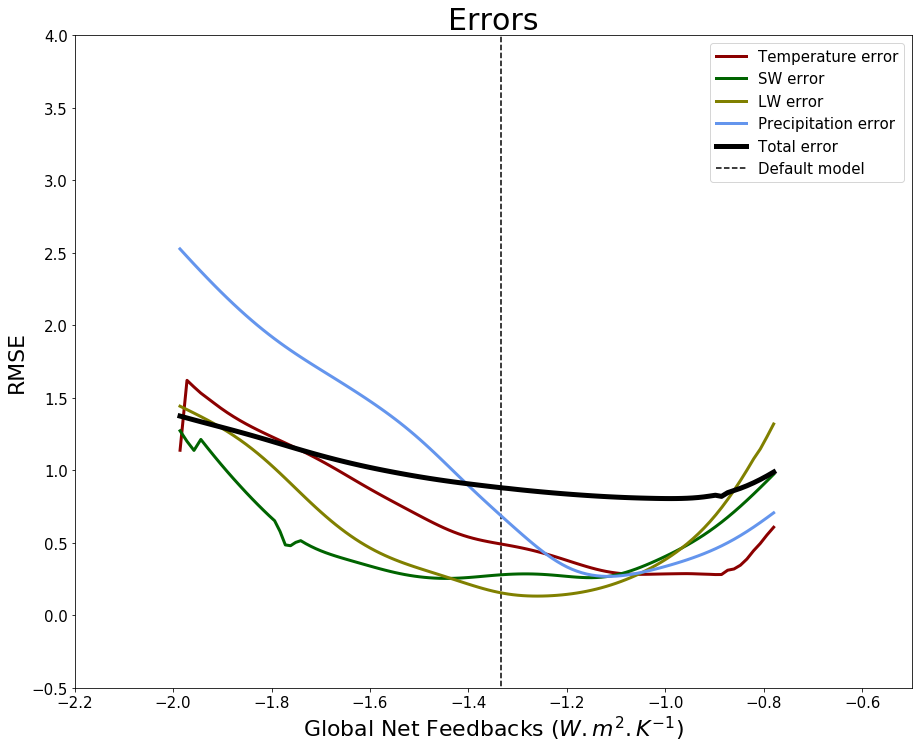

In [14]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

RMSE_optim2_df.plot(kind='line', x='Fdbck_tas', y='tas', color = 'darkred', 
         linewidth=3, figsize=(15, 12),  ax = ax)

RMSE_optim2_df.plot(kind='line', x='Fdbck_SW', y='SW', color = 'darkgreen', 
         linewidth=3,  ax = ax)

RMSE_optim2_df.plot(kind='line', x='Fdbck_LW', y='LW', color = 'olive', 
         linewidth=3,  ax = ax)

RMSE_optim2_df.plot(kind='line', x='Fdbck_pr', y='pr', color = 'cornflowerblue', 
         linewidth=3,  ax = ax)

RMSE_optim2_df.plot(kind='line', x='Fdbck_total', y='total', color = 'black', 
         linewidth=5,  ax = ax)

plt.vlines(p1_feedbacks,ymin = -1000,ymax = 1000,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model',
legend = legend = [ 'Temperature error', 'SW error', 'LW error', 'Precipitation error', 'Total error',
                   'Default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel('RMSE', fontsize=22)
plt.legend(legend, fontsize=15)
plt.title('Errors', fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4.0)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/Feedback_likelihood.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()